In [1]:
from keras.datasets import mnist 

# MNIST Load Normalization
(x_train, _), (x_test, _) = mnist.load_data()
y_train = x_train[:1000].astype('float32') / 255.
y_test = x_test[:1000].astype('float32') / 255. 

print(y_train.shape)
print(y_test.shape)

Using TensorFlow backend.


(1000, 28, 28)
(1000, 28, 28)


In [2]:
# conv2d input reshape (width*height*cannel)
y_train = y_train.reshape((y_train.shape[0],28,28,1))
y_test = y_test.reshape((y_test.shape[0],28,28,1))
print(y_train.shape)
print(y_test.shape)

(1000, 28, 28, 1)
(1000, 28, 28, 1)


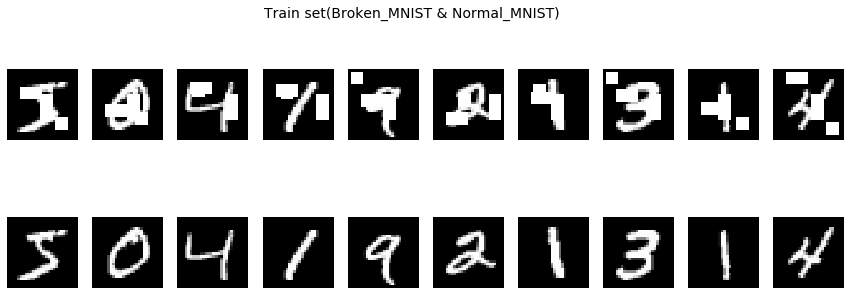

In [3]:
import numpy as np 

x_train = y_train.copy()

# noise range
rn = 5

# 랜덤 깨진 MNISt 만들기 
for i in range(0, x_train.shape[0]) : 
    ix = np.random.randint(0, x_train.shape[1]-rn)
    iz = np.random.randint(0, x_train.shape[1]-rn)
    ic = np.random.randint(0, x_train.shape[1]-rn)
    x_train[i, 10:20, ix:ix+rn] = 1.
    x_train[i, iz:iz+rn , 5:14] = 1.
    x_train[i, ic:ic+rn , ic:ic+rn] = 1.

import matplotlib.pyplot as plt 

fig, axs = plt.subplots(2,10, figsize=(15, 5))
for i in range(10) :
    fig.suptitle('Train set(Broken_MNIST & Normal_MNIST)', fontsize=14)
    axs[0, i].set_axis_off()
    axs[0, i].imshow(x_train[i].reshape(28,28), cmap='gray')
    axs[1, i].set_axis_off()
    axs[1, i].imshow(y_train[i].reshape(28,28), cmap='gray')
plt.show()
plt.close(fig)

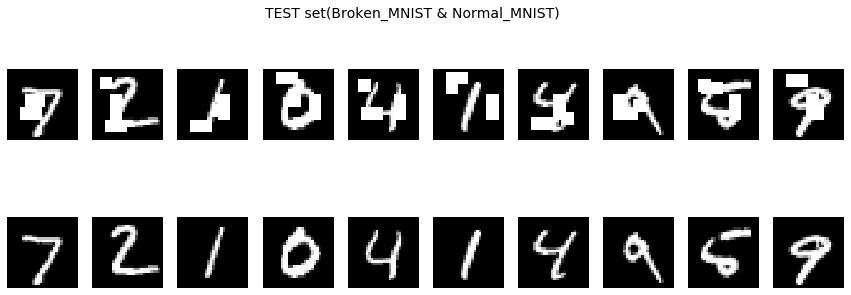

In [4]:
x_test = y_test.copy()

# 랜덤 깨진 MNISt 만들기 
for i in range(0, x_test.shape[0]) : 
    ix = np.random.randint(0, x_test.shape[1]-rn)
    iz = np.random.randint(0, x_test.shape[1]-rn)
    ic = np.random.randint(0, x_test.shape[1]-rn)
    x_test[i, 10:20, ix:ix+rn] = 1.
    x_test[i, iz:iz+rn , 5:14] = 1.
    x_test[i, ic:ic+rn , ic:ic+rn] = 1.

import matplotlib.pyplot as plt 

fig, axs = plt.subplots(2,10, figsize=(15, 5))
for i in range(10) :
    fig.suptitle('TEST set(Broken_MNIST & Normal_MNIST)', fontsize=14)
    axs[0, i].set_axis_off()
    axs[0, i].imshow(x_test[i].reshape(28,28), cmap='gray')
    axs[1, i].set_axis_off()
    axs[1, i].imshow(y_test[i].reshape(28,28), cmap='gray')
plt.show()
plt.close(fig)

In [5]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def unet(input_size=(28,28,1)):
    inputs = Input(input_size)
    depth = 14

    conv1 = Conv2D(depth*1, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(depth*1, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(depth*2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(depth*2, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(depth*4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(depth*4, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)

    up1 = concatenate([Conv2DTranspose(depth*2, (2, 2), strides=(2, 2), padding='same')(conv3), conv2], axis=3)
    dconv1 = Conv2D(depth*2, (3, 3), activation='relu', padding='same')(up1)
    dconv1 = BatchNormalization()(dconv1)
    dconv1 = Conv2D(depth*2, (3, 3), activation='relu', padding='same')(dconv1)
    dconv1 = BatchNormalization()(dconv1)

    up2 = concatenate([Conv2DTranspose(depth*1, (2, 2), strides=(2, 2), padding='same')(dconv1), conv1], axis=3)
    dconv2 = Conv2D(depth*1, (3, 3), activation='relu', padding='same')(up2)
    dconv2 = BatchNormalization()(dconv2)
    dconv2 = Conv2D(depth*1, (3, 3), activation='relu', padding='same')(dconv2)
    dconv2 = BatchNormalization()(dconv2)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(dconv2)
    return Model(inputs=[inputs], outputs=[outputs])

# 모델 생성
model = unet()

# 모델 컴파일
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 14)   140         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 14)   56          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 14)   1778        batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [6]:
# 학습
hist = model.fit(x_train, y_train, validation_split=0.3, epochs=10, batch_size=3, verbose=1)

# 모델 저장
model.save('./model/unet.h5')

Train on 700 samples, validate on 300 samples
Epoch 1/10
700/700 [==============================] - 6s 9ms/step - loss: 0.3127 - accuracy: 0.7826 - val_loss: 0.4104 - val_accuracy: 0.7152
Epoch 2/10
700/700 [==============================] - 3s 4ms/step - loss: 0.1407 - accuracy: 0.8152 - val_loss: 0.1568 - val_accuracy: 0.7868
Epoch 3/10
700/700 [==============================] - 3s 4ms/step - loss: 0.1093 - accuracy: 0.8162 - val_loss: 0.1239 - val_accuracy: 0.7903
Epoch 4/10
700/700 [==============================] - 3s 4ms/step - loss: 0.0982 - accuracy: 0.8163 - val_loss: 0.0979 - val_accuracy: 0.8046
Epoch 5/10
700/700 [==============================] - 3s 4ms/step - loss: 0.0893 - accuracy: 0.8171 - val_loss: 0.0944 - val_accuracy: 0.8028
Epoch 6/10
700/700 [==============================] - 3s 4ms/step - loss: 0.0843 - accuracy: 0.8174 - val_loss: 0.0922 - val_accuracy: 0.8021
Epoch 7/10
700/700 [==============================] - 3s 4ms/step - loss: 0.0806 - accuracy: 0.8178 - 

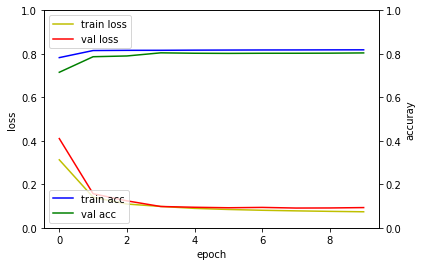

In [7]:

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()
plt.close()

1/1 [==============================] - 0s 3ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


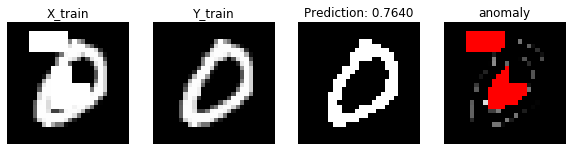

1/1 [==============================] - 0s 3ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


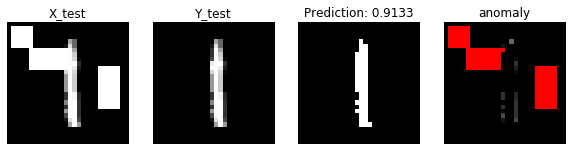

In [8]:
def plotPredictions(model, x_train, y_train, x_test, y_test):
    ix = np.random.randint(0, len(x_train))

    input_ = x_train[ix:ix+1]
    mask_ = y_train[ix:ix+1]

    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0].reshape((28,28)), 'gray')

    plt.subplot(1,4,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')

    plt.subplot(1,4,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')

    # train 이상 영역
    train_residual = input_ - preds_train_t
    train_residual_ = train_residual.reshape((28,28))
    train_residual_ = np.stack((train_residual_,)*3, -1) # 3채널로 변경 RGB 형식
    rows, cols, channels = train_residual_.shape

    # changing 255 to 0 in first channel
    for i in range(rows): 
        for j in range(cols):
            if train_residual_[i, j, 0] == 1 :
                train_residual_[i, j, 0] = 1

    for i in range(rows):
        for j in range(cols):
            if train_residual_[i, j, 1] == 1 :
                train_residual_[i, j, 1] = 0

    for i in range(rows):
        for j in range(cols):
            if train_residual_[i, j, 2] == 1 :
                train_residual_[i, j, 2] = 0            

    plt.subplot(1,4,4)
    plt.title("anomaly")
    plt.axis('off')
    plt.imshow(train_residual_)
    plt.show()
    plt.close()

    ix = np.random.randint(0, len(x_test))
    input_ = x_test[ix:ix+1]
    mask_ = y_test[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0].reshape((28,28)), 'gray')

    plt.subplot(1,4,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')

    plt.subplot(1,4,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')

    # test 이상 영역
    test_residual = input_ - preds_test_t
    test_residual_ = test_residual.reshape((28,28))
    test_residual_ = np.stack((test_residual_,)*3, -1) # 3채널로 변경 RGB 형식
    rows, cols, channels = test_residual_.shape
    
    # changing 255 to 0 in first channel
    for i in range(rows):
        for j in range(cols):
            if test_residual_[i, j, 0] == 1 :
                test_residual_[i, j, 0] = 1

    for i in range(rows):
        for j in range(cols):
            if test_residual_[i, j, 1] == 1 :
                test_residual_[i, j, 1] = 0

    for i in range(rows):
        for j in range(cols):
            if test_residual_[i, j, 2] == 1 :
                test_residual_[i, j, 2] = 0            

    plt.subplot(1,4,4)
    plt.title("anomaly")
    plt.axis('off')
    plt.imshow(test_residual_)
    plt.show()
    plt.close()

# 색칠하기
plotPredictions(model, x_train, y_train, x_test, y_test)

1/1 [==============================] - 0s 3ms/step


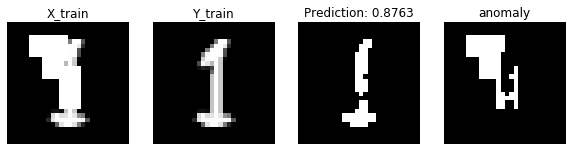

1/1 [==============================] - 0s 3ms/step


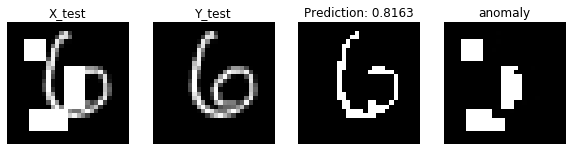

In [9]:
def plotPredictions(model, x_train, y_train, x_test, y_test):
    ix = np.random.randint(0, len(x_train))

    input_ = x_train[ix:ix+1]
    mask_ = y_train[ix:ix+1]

    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0].reshape((28,28)), 'gray')

    plt.subplot(1,4,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')

    plt.subplot(1,4,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')

    # train 이상 영역
    train_residual = input_ - preds_train_t
    train_residual_ = train_residual.reshape((28,28,1))
    rows, cols, channels = train_residual_.shape
    pixel_value_to_replace = 255
    # changing 255 to 0 in first channel
    for i in range(rows):
        for j in range(cols):
            if train_residual_[i, j, 0] == 1 :
                train_residual_[i, j, 0] = 255

    plt.subplot(1,4,4)
    plt.title("anomaly")
    plt.axis('off')
    plt.imshow(train_residual_.reshape((28,28)), 'gray')
    plt.show()
    plt.close()

    ix = np.random.randint(0, len(x_test))
    input_ = x_test[ix:ix+1]
    mask_ = y_test[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0].reshape((28,28)), 'gray')

    plt.subplot(1,4,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')

    plt.subplot(1,4,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')

    # test 이상 영역
    test_residual = input_ - preds_test_t
    test_residual_ = test_residual.reshape((28,28,1))
    rows, cols, channels = test_residual_.shape
    pixel_value_to_replace = 255
    # changing 255 to 0 in first channel
    for i in range(rows):
        for j in range(cols):
            if test_residual_[i, j, 0] == 1 :
                test_residual_[i, j, 0] = 255

    plt.subplot(1,4,4)
    plt.title("anomaly")
    plt.axis('off')
    plt.imshow(test_residual_.reshape((28,28)), 'gray')
    plt.show()
    plt.close()

# gray scale
plotPredictions(model, x_train, y_train, x_test, y_test)